<h1>Surprise Housing - Advanced Regression</h1>

In [413]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from scipy import stats
from scipy.stats import norm, skew
import os

# hide warnings
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [414]:
#Importing Data
housingdata = pd.read_csv("train.csv")
print(housingdata.shape)

(1460, 81)


<h2>1. Exploratory Data Analysis</h2>

In [415]:
housingdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [416]:
#Identify insignificant columns
fewer_value_columns = [col for col in housingdata.columns if housingdata[col].nunique(dropna=True) <= 2]
for col in fewer_value_columns:
    print(housingdata.groupby([col])[col].count())

Street
Grvl       6
Pave    1454
Name: Street, dtype: int64
Alley
Grvl    50
Pave    41
Name: Alley, dtype: int64
Utilities
AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64
CentralAir
N      95
Y    1365
Name: CentralAir, dtype: int64


In [417]:
#Drop columns with values that are less significant
#Dropping Utilities and Street since most of the rows has same values
housingdata = housingdata.drop(['Id', 'Street', 'Utilities' ] , axis=1)
print(housingdata.shape)

(1460, 78)


<h3> Data Imputation</h3>

In [418]:
#Identify categorical variables with null values
object_columns_with_null = housingdata.select_dtypes(include=['object']).columns[housingdata.select_dtypes(include=['object']).apply(lambda x: x.isnull().any())]
print(object_columns_with_null)

Index(['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC',
       'Fence', 'MiscFeature'],
      dtype='object')


In [419]:
# Except for 'Electrical' none is a valid value for all the other columns as per data definition
print(housingdata['Electrical'].mode()[0])
#Imputing most common value
housingdata['Electrical'] = housingdata['Electrical'].fillna(housingdata['Electrical'].mode()[0])

SBrkr


In [420]:
# Imputing other objects columns with value 'None', since they are valid options
object_columns_with_null = housingdata.select_dtypes(include=['object']).columns[housingdata.select_dtypes(include=['object']).apply(lambda x: x.isnull().any())]
print(object_columns_with_null)
for col in object_columns_with_null:
    housingdata[col] = housingdata[col].fillna('None')

print(housingdata.select_dtypes(include=['object']).columns[housingdata.select_dtypes(include=['object']).apply(lambda x: x.isnull().any())])

Index(['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')
Index([], dtype='object')


In [515]:
#Identify numerical variables with null values
numeric_columns_with_null = housingdata.select_dtypes(include=['int64', 'float64']).columns[housingdata.select_dtypes(include=['int', 'float']).apply(lambda x: x.isnull().any())]
print(numeric_columns_with_null)

Index([], dtype='object')


In [422]:
# Dropping LotFrontage since good volume of data is missing this cant be imputed with 0 and imputing 'MasVnrArea', 'GarageYrBlt' with 0
housingdata = housingdata.drop(['LotFrontage' ] , axis=1)
housingdata['MasVnrArea'] = housingdata['MasVnrArea'].fillna(0)
housingdata['GarageYrBlt'] = housingdata['GarageYrBlt'].fillna(0)

In [423]:
columns_with_null = housingdata.columns[housingdata.apply(lambda x: x.isnull().any())]
print(columns_with_null)

Index([], dtype='object')


In [424]:
housingdata.describe()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.117123,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1868.739726,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,9981.264932,1.382997,1.112799,30.202904,20.645407,180.731373,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,453.697295,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1958.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1977.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,164.250000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2001.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [425]:
#Transforming categorical features
housingdata['MSSubClass'] = housingdata['MSSubClass'].apply(str)
housingdata['YrSold'] = housingdata['YrSold'].astype(str)
housingdata['MoSold'] = housingdata['MoSold'].astype(str)
housingdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 77 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   object 
 1   MSZoning       1460 non-null   object 
 2   LotArea        1460 non-null   int64  
 3   Alley          1460 non-null   object 
 4   LotShape       1460 non-null   object 
 5   LandContour    1460 non-null   object 
 6   LotConfig      1460 non-null   object 
 7   LandSlope      1460 non-null   object 
 8   Neighborhood   1460 non-null   object 
 9   Condition1     1460 non-null   object 
 10  Condition2     1460 non-null   object 
 11  BldgType       1460 non-null   object 
 12  HouseStyle     1460 non-null   object 
 13  OverallQual    1460 non-null   int64  
 14  OverallCond    1460 non-null   int64  
 15  YearBuilt      1460 non-null   int64  
 16  YearRemodAdd   1460 non-null   int64  
 17  RoofStyle      1460 non-null   object 
 18  RoofMatl

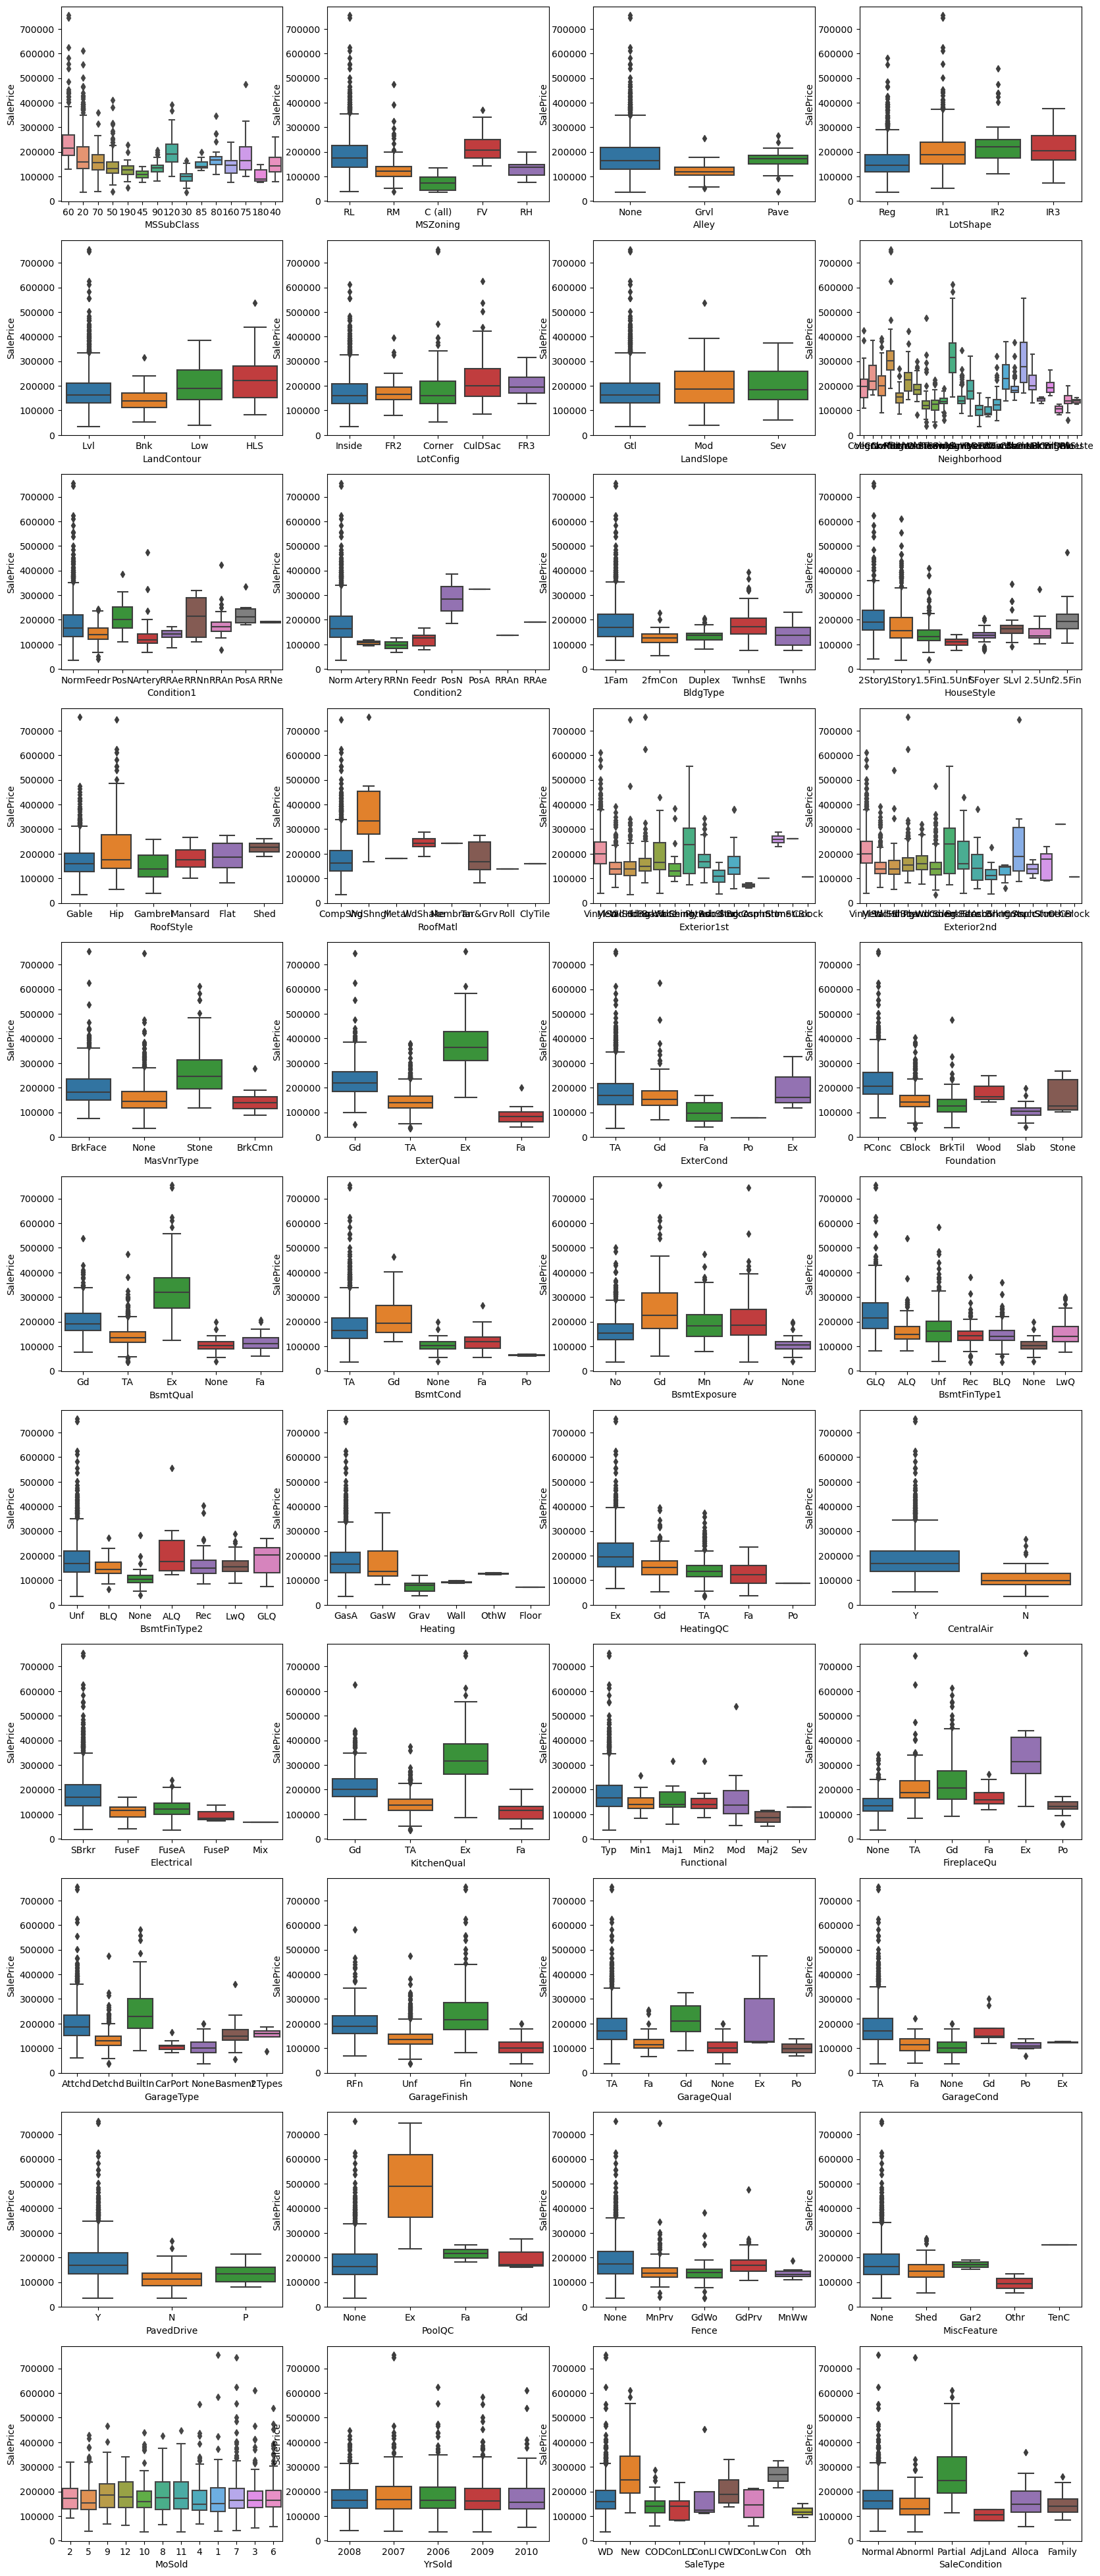

In [426]:
# Visualize categorical variables
def boxplot(categorical,target):
    plt.figure(figsize=(20, 50))
    for i in range(0,len(categorical)):
        plt.subplot(11,4,i+1)
        sns.boxplot(x = categorical[i], y = target, data = housingdata)
    plt.show()
    
categorical =housingdata.select_dtypes(include=['object']).columns
boxplot(categorical,'SalePrice')
#print(len(categorical))
#outliers are the ones with excellent pool condition
#SaleType 'New' is sold higher price in general compared to other ones
#KitchenQual BsmtQual ExterQual of type Excellent are generally sold higher price

In [427]:
#Creating Dummy Numeric variable overall square feet since all sqft features has good corr and dropping others
housingdata['TotSqft'] = housingdata['TotalBsmtSF'] + housingdata['1stFlrSF'] + housingdata['2ndFlrSF']
housingdata = housingdata.drop(['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF'] , axis=1)

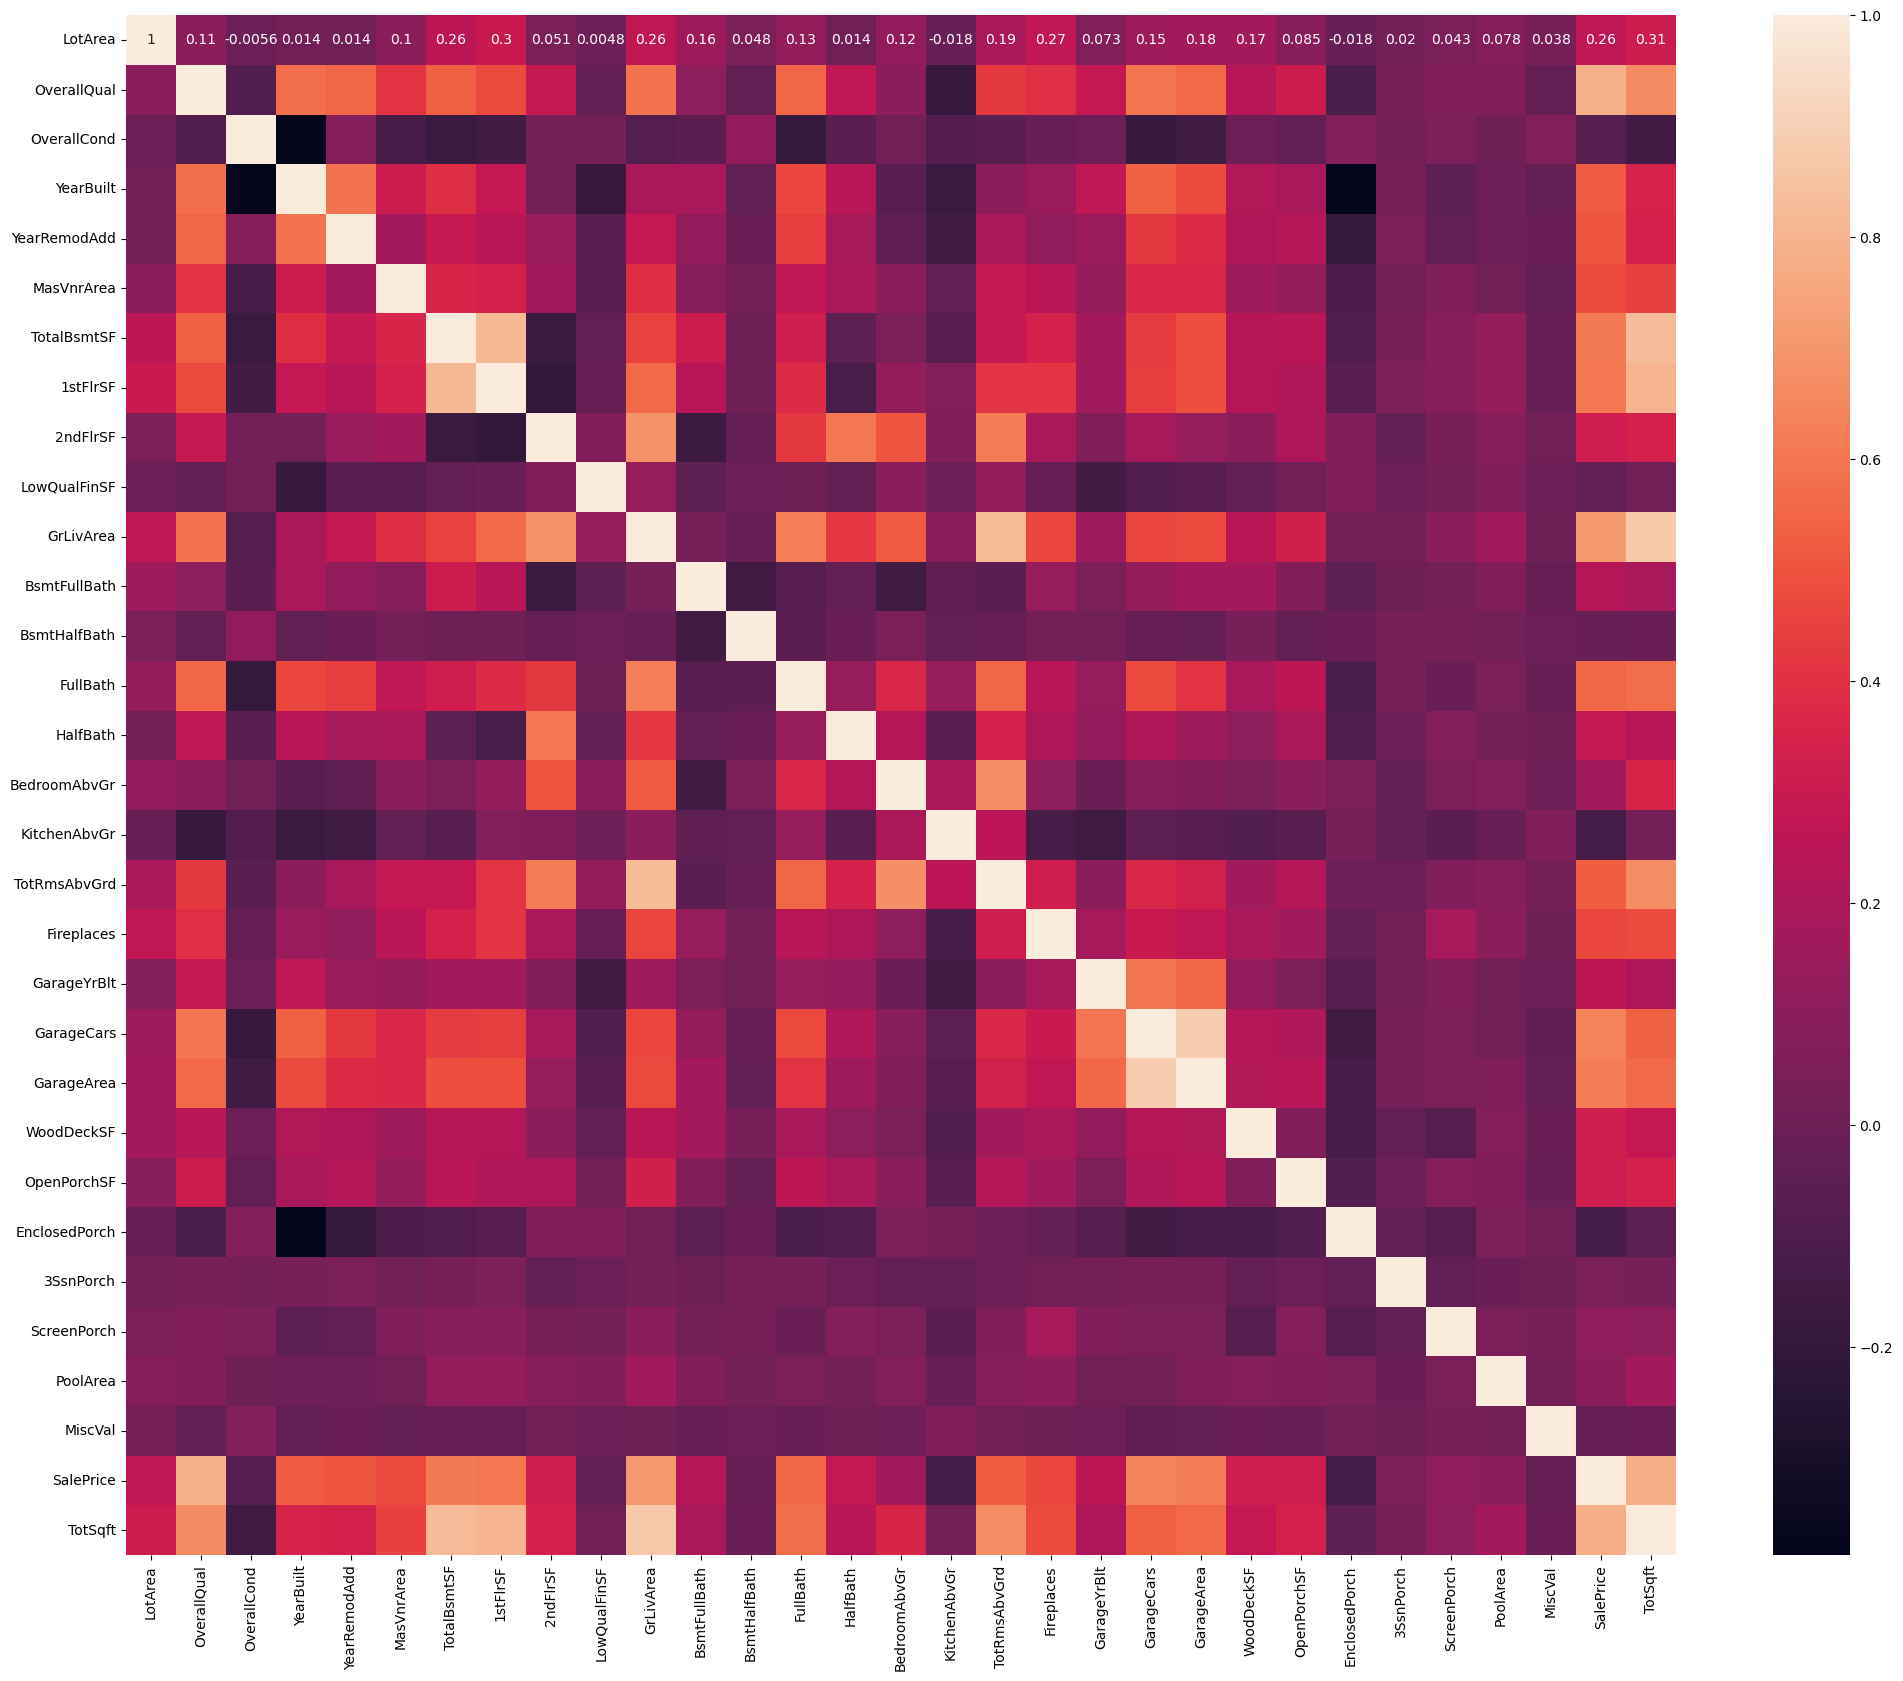

In [428]:
# Visualize numeric variables
numerical =housingdata.select_dtypes(include=['int', 'float'])
plt.figure(figsize=(25,20))
sns.heatmap(numerical.corr(), annot=True);

<h3>Creating Dummy Variables</h3>

In [429]:
# creating dummy variables for categorical variables
housingdata_categorical = housingdata.select_dtypes(include=['object'])
housingdata_categorical.head()

,MSSubClass,MSZoning,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,None,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,None,Attchd,RFn,TA,TA,Y,None,None,None,2,2008,WD,Normal
1,20,RL,None,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,None,None,None,5,2007,WD,Normal
2,60,RL,None,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,None,None,None,9,2008,WD,Normal
3,70,RL,None,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,None,None,None,2,2006,WD,Abnorml
4,60,RL,None,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,None,None,None,12,2008,WD,Normal


In [430]:
# convert into dummies - one hot encoding
housingdata_dummies = pd.get_dummies(housingdata_categorical, drop_first=True, dtype=int)
housingdata_dummies.head()

,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Alley_None,Alley_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,BsmtCond_Gd,BsmtCond_None,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_None,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_None,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_None,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,PoolQC_Fa,PoolQC_Gd,PoolQC_None,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MoSold_10,MoSold_11,MoSold_12,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,0,0,0

In [431]:
# drop categorical variables 
housingdata = housingdata.drop(list(housingdata_categorical.columns), axis=1)
# concat dummy variables with X
housingdata = pd.concat([housingdata, housingdata_dummies], axis=1)
housingdata.shape

(1460, 281)

<h3>Removing outliers</h3>

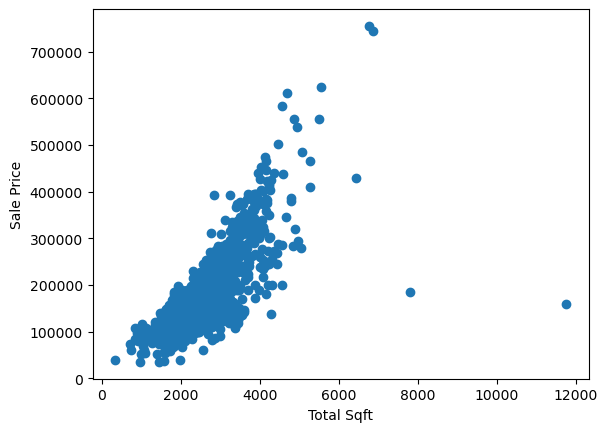

In [432]:
#Sale price above 700k clearly seems to the outlier among all categories
#housingdata = housingdata.drop(housingdata[(housingdata['SalePrice']<300000)].index)

fig,ax=plt.subplots()
ax.scatter(x=housingdata['TotSqft'], y=housingdata['SalePrice'])
plt.ylabel('Sale Price')
plt.xlabel('Total Sqft')
plt.show()

In [433]:
housingdata = housingdata.drop(housingdata[(housingdata['TotSqft']>7000) & (housingdata['SalePrice']<300000)].index)

<h3> Transforming Target Variable</h3>

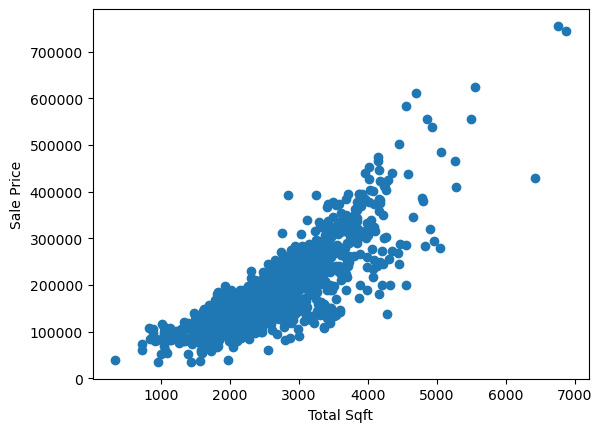

In [434]:
fig,ax=plt.subplots()
ax.scatter(x=housingdata['TotSqft'], y=housingdata['SalePrice'])
plt.ylabel('Sale Price')
plt.xlabel('Total Sqft')
plt.show()

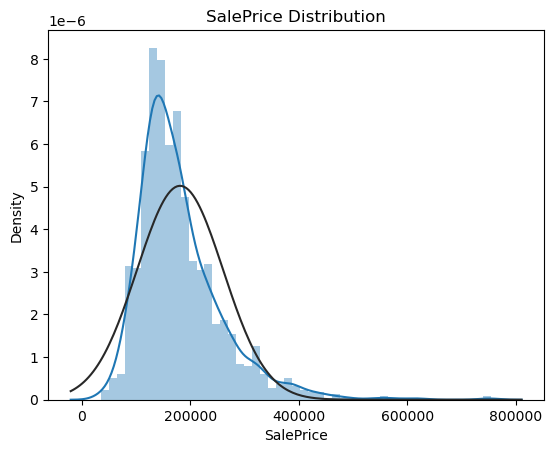

In [435]:
plt.title('SalePrice Distribution')
sns.distplot(housingdata['SalePrice'],fit=norm);
plt.show()

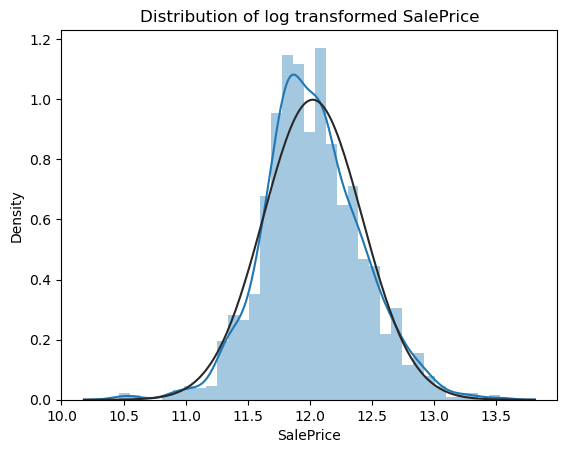

In [436]:
#Performing log transformation for target variables
sns.distplot(np.log(housingdata['SalePrice']),fit=norm)
plt.title('Distribution of log transformed SalePrice')
plt.show()

In [437]:
housingdata['SalePrice'] = np.log(housingdata['SalePrice'])
print(housingdata['SalePrice'].head(5))

0    12.247694
1    12.109011
2    12.317167
3    11.849398
4    12.429216
Name: SalePrice, dtype: float64


## 2. Model Building and Evaluation

In [438]:
#Dividing X and Y
#day_model_train.info()
y = housingdata['SalePrice']
X = housingdata.drop(['SalePrice'], axis=1)

In [439]:
# Test Train Split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)

<h3> Building OLS Model</h3>

In [440]:
# Running RFE with the output number of the variable equal to 20
rfe = RFE(estimator=lm, n_features_to_select=20)
rfe = rfe.fit(X_train, y_train)

In [441]:
featurelist = list(zip(X_train.columns,rfe.support_,rfe.ranking_))
[(x,z) for x,y,z in featurelist if z==1]
#filtering features with rank 1

[('TotalBsmtSF', 1),
 ('LowQualFinSF', 1),
 ('GrLivArea', 1),
 ('KitchenAbvGr', 1),
 ('TotSqft', 1),
 ('MSZoning_FV', 1),
 ('MSZoning_RH', 1),
 ('MSZoning_RL', 1),
 ('MSZoning_RM', 1),
 ('RoofStyle_Shed', 1),
 ('RoofMatl_Membran', 1),
 ('Exterior1st_BrkComm', 1),
 ('Exterior2nd_CBlock', 1),
 ('BsmtCond_Po', 1),
 ('Heating_Grav', 1),
 ('Functional_Maj2', 1),
 ('Functional_Sev', 1),
 ('MiscFeature_TenC', 1),
 ('SaleType_New', 1),
 ('SaleCondition_Partial', 1)]

In [442]:
col = X_train.columns[rfe.support_]

In [482]:
#Train Model
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]
X_test_rfe = X_test[col]

import statsmodels.api as sm  
X_train_rfe = sm.add_constant(X_train_rfe)
lm1 = sm.OLS(y_train,X_train_rfe).fit()   # Running the linear model
print(lm1.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     221.3
Date:                Fri, 29 Dec 2023   Prob (F-statistic):               0.00
Time:                        02:29:05   Log-Likelihood:                 316.78
No. Observations:                1020   AIC:                            -593.6
Df Residuals:                    1000   BIC:                            -495.0
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    10.79

In [444]:
y_pred = lm1.predict(X_train_rfe)

In [445]:
X_test_rfe = sm.add_constant(X_test_rfe)
y_pred_test = lm1.predict(X_test_rfe)

metric = []
r2_train_lr = r2_score(y_train, y_pred)
print(r2_train_lr)
metric.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred))
print(rss1_lr)
metric.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred)
print(mse_train_lr)
metric.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric.append(mse_test_lr**0.5)

0.8078328883382419
0.7494980306372925
32.089855973812654
16.455519525506226
0.03146064311158103
0.037569679281977686


Text(0.5, 0, 'Errors')

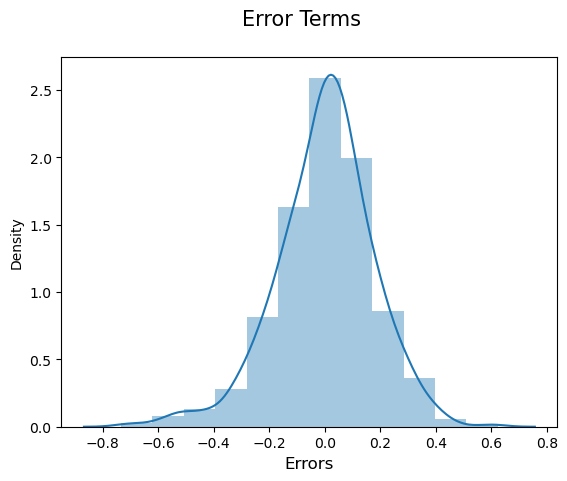

In [446]:
# Plot error terms
fig = plt.figure()
sns.distplot((y_train - y_pred), bins = 12)
fig.suptitle('Error Terms', fontsize = 15)                 
plt.xlabel('Errors', fontsize = 12) 

In [447]:
# Residual analysis
y_res = y_train - y_pred
print(y_res.shape)
print(y_pred.shape)

(1020,)
(1020,)


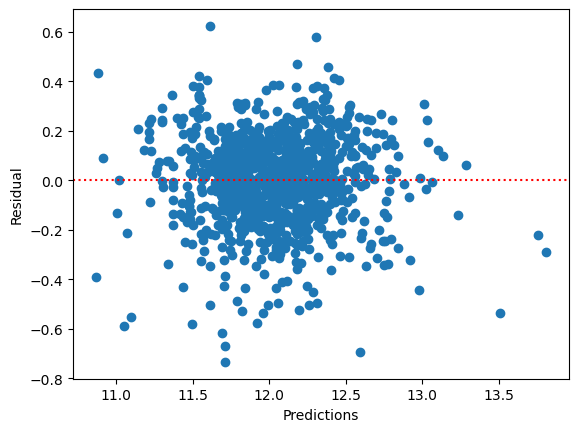

In [448]:
plt.scatter( y_pred , y_res)
plt.axhline(y=0, color='r', linestyle=':')
plt.xlabel("Predictions")
plt.ylabel("Residual")
plt.show()

#spread out randomly around zero axis without any pattern

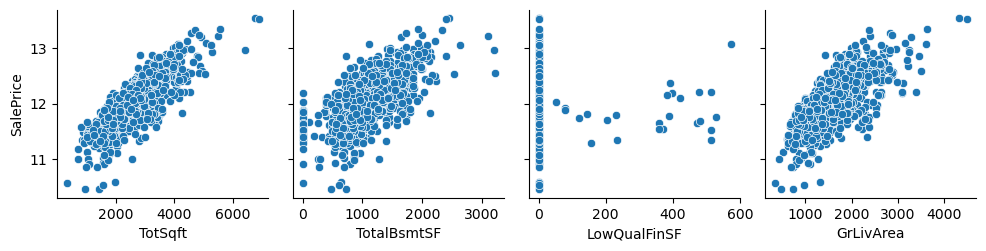

In [449]:
# Visualize numeric features

sns.pairplot(data=housingdata,
                  x_vars=['TotSqft','TotalBsmtSF', 'LowQualFinSF', 'GrLivArea' ] ,y_vars=['SalePrice'])
plt.show()


<h3>Ridge Regression</h3>

In [450]:
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 
#https://scikit-learn.org/stable/modules/model_evaluation.html

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [451]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 20}


In [452]:
alpha = 20
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
print(ridge.coef_)

[ 2.45151737e-06  4.82483052e-02  4.59591859e-02  2.38237879e-03
  1.04098267e-03  2.95039718e-05  3.19415602e-05  2.88200920e-05
  5.35740176e-05  4.00363641e-05  1.22430471e-04  2.81280718e-02
 -6.27296907e-03  9.40099724e-03  2.25900392e-02 -6.77688007e-03
 -2.81143561e-02 -2.03270322e-03  1.59541956e-02  3.08065653e-05
  2.06063572e-02  8.15909688e-05  7.49941957e-05  9.94634132e-05
  7.47269862e-05  9.98000216e-05  1.43251380e-04  2.24253535e-05
 -1.07754733e-06  1.14335675e-04 -4.56645995e-02 -1.64187444e-02
 -1.07682823e-02  2.26240873e-02 -3.04740576e-02  7.70806737e-04
  7.31724058e-03  1.76638660e-02  4.91489962e-05  4.66088991e-02
  4.12264203e-03  1.17797922e-02  2.22677104e-03 -3.31741693e-03
  4.00860366e-02  5.53687022e-03  4.29783775e-02 -1.00238179e-02
 -1.02318453e-02  8.63203880e-03 -4.32094899e-04  5.82858568e-03
  7.78082083e-03  1.21296898e-02 -2.48806467e-03  2.56956476e-03
  2.51318683e-02 -9.90519568e-03 -4.39346583e-03 -6.38522634e-03
  2.33180272e-02 -2.96699

In [453]:
# Lets calculate some metrics such as R2 score, RSS and RMSE
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

metric2 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric2.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric2.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric2.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric2.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric2.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric2.append(mse_test_lr**0.5)

0.9432235166478682
0.8979788076979085
9.481066545228494
6.701790513717288
0.009295163279635778
0.015300891583829425


<h3>Lasso Regression</h3>

In [464]:
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [465]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 0.001}


In [466]:
#Fitting Ridge model for alpha = 100 and printing coefficients which have been penalised

alpha =0.001

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=0.001)

In [467]:
lasso.coef_

array([ 2.27825148e-06,  5.49618171e-02,  4.72192906e-02,  2.64108707e-03,
        1.00120235e-03,  2.94852875e-05,  2.45136604e-04,  3.19349311e-04,
        3.40141638e-04,  1.11685425e-04,  5.85581718e-05,  2.69529417e-02,
       -0.00000000e+00,  0.00000000e+00,  1.35583965e-02, -3.56348455e-03,
       -2.89261845e-02, -0.00000000e+00,  2.05348666e-02,  3.39081770e-05,
        8.79180842e-03,  1.21771254e-04,  8.78298275e-05,  8.62460791e-05,
        9.01826468e-05,  8.39894790e-05,  1.58278736e-04, -8.45550021e-06,
       -1.00493973e-06, -1.02568991e-04, -4.84865573e-02, -0.00000000e+00,
       -0.00000000e+00,  7.72949011e-03, -2.55865796e-02,  0.00000000e+00,
        0.00000000e+00,  8.69813580e-03, -0.00000000e+00,  3.62838475e-02,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        8.20330810e-02,  0.00000000e+00,  5.87597573e-02, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [468]:
# Lets calculate some metrics such as R2 score, RSS and RMSE

y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric3.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric3.append(mse_test_lr**0.5)

0.9351200963357011
0.9029782958385661
10.834251221128767
6.373373236498163
0.010621814922675261
0.014551080448625943


<h3>Model Comparision</h3>

In [470]:
# Creating a table which contain all the metrics

lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)'], 
        'Linear Regression': metric
        }

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )

rg_metric = pd.Series(metric2, name = 'Ridge Regression')
ls_metric = pd.Series(metric3, name = 'Lasso Regression')

final_metric = pd.concat([lr_metric, rg_metric, ls_metric], axis = 1)
final_metric

,Metric,Linear Regression,Ridge Regression,Lasso Regression
0,R2 Score (Train),0.807833,0.943224,0.935120
1,R2 Score (Test),0.749498,0.897979,0.902978
2,RSS (Train),32.089856,9.481067,10.834251
3,RSS (Test),16.455520,6.701791,6.373373
4,MSE (Train),0.177371,0.096411,0.103062
5,MSE (Test),0.193829,0.123697,0.120628


In [498]:
feature_coeffs = pd.DataFrame(index=X.columns)
feature_coeffs.rows = X.columns
feature_coeffs['Ridge'] = ridge.coef_
feature_coeffs['Lasso'] = lasso.coef_
print(feature_coeffs)

                          Ridge     Lasso
LotArea                0.000002  0.000002
OverallQual            0.048248  0.054962
OverallCond            0.045959  0.047219
YearBuilt              0.002382  0.002641
YearRemodAdd           0.001041  0.001001
MasVnrArea             0.000030  0.000029
TotalBsmtSF            0.000032  0.000245
1stFlrSF               0.000029  0.000319
2ndFlrSF               0.000054  0.000340
LowQualFinSF           0.000040  0.000112
GrLivArea              0.000122  0.000059
BsmtFullBath           0.028128  0.026953
BsmtHalfBath          -0.006273 -0.000000
FullBath               0.009401  0.000000
HalfBath               0.022590  0.013558
BedroomAbvGr          -0.006777 -0.003563
KitchenAbvGr          -0.028114 -0.028926
TotRmsAbvGrd          -0.002033 -0.000000
Fireplaces             0.015954  0.020535
GarageYrBlt            0.000031  0.000034
GarageCars             0.020606  0.008792
GarageArea             0.000082  0.000122
WoodDeckSF             0.000075  0

In [512]:
## View the features selected by lasso
feature_coeffs.loc[feature_coeffs['Lasso']!=0, 'Lasso'].sort_values(ascending=False)[:10]

Neighborhood_Crawfor    0.093711
SaleType_New            0.086420
MSZoning_FV             0.082033
MSZoning_RL             0.058760
OverallQual             0.054962
SaleCondition_Normal    0.053643
BsmtExposure_Gd         0.051617
OverallCond             0.047219
Functional_Typ          0.043560
MSSubClass_70           0.036284
Name: Lasso, dtype: float64

In [513]:
feature_coeffs.loc[feature_coeffs['Lasso']!=0, 'Lasso'].sort_values(ascending=True)[:10]

MSSubClass_160     -0.048487
BsmtFinType1_Unf   -0.041875
BldgType_Twnhs     -0.034600
KitchenAbvGr       -0.028926
KitchenQual_Gd     -0.027635
BsmtQual_Gd        -0.026247
MSSubClass_30      -0.025587
KitchenQual_TA     -0.023497
YrSold_2009        -0.019286
HeatingQC_TA       -0.018804
Name: Lasso, dtype: float64

In [507]:
feature_coeffs['Ridge'].sort_values(ascending=False)[:10]

Neighborhood_Crawfor    0.067740
SaleCondition_Normal    0.057324
OverallQual             0.048248
Functional_Typ          0.046978
MSSubClass_70           0.046609
OverallCond             0.045959
BsmtExposure_Gd         0.044361
Condition1_Norm         0.043916
MSZoning_RL             0.042978
SaleType_New            0.042702
Name: Ridge, dtype: float64

In [514]:
feature_coeffs['Ridge'].sort_values(ascending=True)[:10]

BsmtFinType1_Unf       -0.045877
MSSubClass_160         -0.045665
BldgType_Twnhs         -0.045198
Neighborhood_MeadowV   -0.034598
KitchenQual_Gd         -0.034515
MSSubClass_30          -0.030474
LandSlope_Sev          -0.029670
BsmtQual_Gd            -0.029597
KitchenQual_TA         -0.029351
KitchenAbvGr           -0.028114
Name: Ridge, dtype: float64

<h3>Conclusions</h3>
Sales prices increases based on the features

- Neighborhood: Crawfor
- SaleType: New
- SaleCondition: Normal
- MSZoning: Floating Village Residential and Residential Low Density
- OverallQual: Higher the quality rated, better the price
- BsmtExposure: Good to walkout or garden level walls
- Functional: Typical functionality with no deductions
- OverallCond: Higher the condition rated, better the price

Sales prices has negative impact based on below features

- MSSubClass: Type 2-STORY PUD - 1946 & NEWER has negative effect on pricing
- BsmtFinType1: When basement area is Unfinshed it has has negative effect on pricing
- BldgType: Building type townhouse inside units has negetive effect